In [2]:
import astropy.units as u
from astropy.io import ascii
from collections import OrderedDict
import numpy as np
from numpy.polynomial.polynomial import polyval
import matplotlib.pyplot as plt
plt.style.use('apw-notebook')
%matplotlib inline
from scipy.optimize import minimize
from scipy.signal import argrelmin
from comoving_rv.longslit.fitting import fit_spec_line
from comoving_rv.longslit.models import voigt_polynomial

import celerite
from celerite.modeling import Model
from celerite import terms, GP

In [ ]:
# from astropy.table import Table

In [ ]:
# derp = Table.read("../data/mdm-spring-2017/processed/n1/1d_n1.0023.fit")

In [ ]:
# for pix in tbl['pixel']:
#     plt.figure(figsize=(8,8))
    
#     idx = (derp['pix'] > (pix - 15)) & (derp['pix'] < (pix+15))
    
#     plt.errorbar(derp['pix'][idx], derp['flux'][idx], derp['ivar'][idx], 
#                  ecolor='#666666', marker='', drawstyle='steps-mid')
    
#     sub_idx = (derp['pix'] > (pix - 5.)) & (derp['pix'] < (pix+5.))
#     pars = fit_spec_line(derp['pix'][sub_idx], derp['flux'][sub_idx], derp['ivar'][sub_idx],
#                          n_bg_coef=3, absorp_emiss=1., 
#                          fwhm_L0=1E-3, std_G0=0.75)
#     grid = np.linspace(min(derp['pix'][sub_idx]), max(derp['pix'][sub_idx]), 256)
#     plt.plot(grid, voigt_polynomial(grid, **pars), marker='', color='#3182bd', alpha=0.4)
    
#     plt.yscale('log')
#     plt.axvline(pars['x0'], zorder=-100, alpha=0.2, color='r')
#     plt.axvline(np.sum(derp['pix'][sub_idx]*derp['flux'][sub_idx]) / np.sum(derp['flux'][sub_idx]), 
#                 color='g', alpha=0.3)

# #     break

In [ ]:
tbl = ascii.read("../data/mdm-spring-2017/processed/wavelength_guess.csv")#[1:]
# tbl.remove_row(np.argmin(np.abs(tbl['pixel']-506.84778)))
tbl

In [ ]:
class MeanModel(Model):

    def __init__(self, n_bg_coef, **p0):
        self._n_bg_coef = n_bg_coef
        self.parameter_names = (["a{}".format(i) for i in range(n_bg_coef)])
        super(MeanModel, self).__init__(**p0)

    def get_value(self, x):
        return polyval(x, np.atleast_1d([getattr(self, "a{}".format(i))
                                         for i in range(self._n_bg_coef)]))

In [ ]:
med_x = np.median(tbl['pixel'])
x = tbl['pixel'] - med_x
y = tbl['wavelength']

idx = np.argsort(x)
x = x[idx]
y = y[idx]

In [374]:
# estimate background
a1 = (y[-1]-y[0])/(x[-1]-x[0]) # slope
a0 = y[-1] - a1*x[-1] # estimate constant term

In [375]:
# initialize model
n_bg_coef = 3
mean_model = MeanModel(n_bg_coef=n_bg_coef, a0=a0, a1=a1, 
                       **dict([('a{}'.format(i),0.) for i in range(2,n_bg_coef)]))
kernel = terms.Matern32Term(log_sigma=np.log(1.), log_rho=np.log(10.)) # MAGIC NUMBERs

# set up the gp model
gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
gp.compute(x, yerr=0.05) # MAGIC NUMBER: need to do this
init_params = gp.get_parameter_vector()
print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))

Initial log-likelihood: -167.2011735032459


In [376]:
# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(y)
    if np.isnan(ll):
        return np.inf
    return -ll

In [377]:
# Fit for the maximum likelihood parameters
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, init_params, method="L-BFGS-B",
                bounds=bounds, args=(y, gp))
gp.set_parameter_vector(soln.x)

if not soln.success:
    print(soln)
else:
    print("Success: {}, Final log-likelihood: {}".format(soln.success, -soln.fun))

Success: True, Final log-likelihood: -54.73240729032656


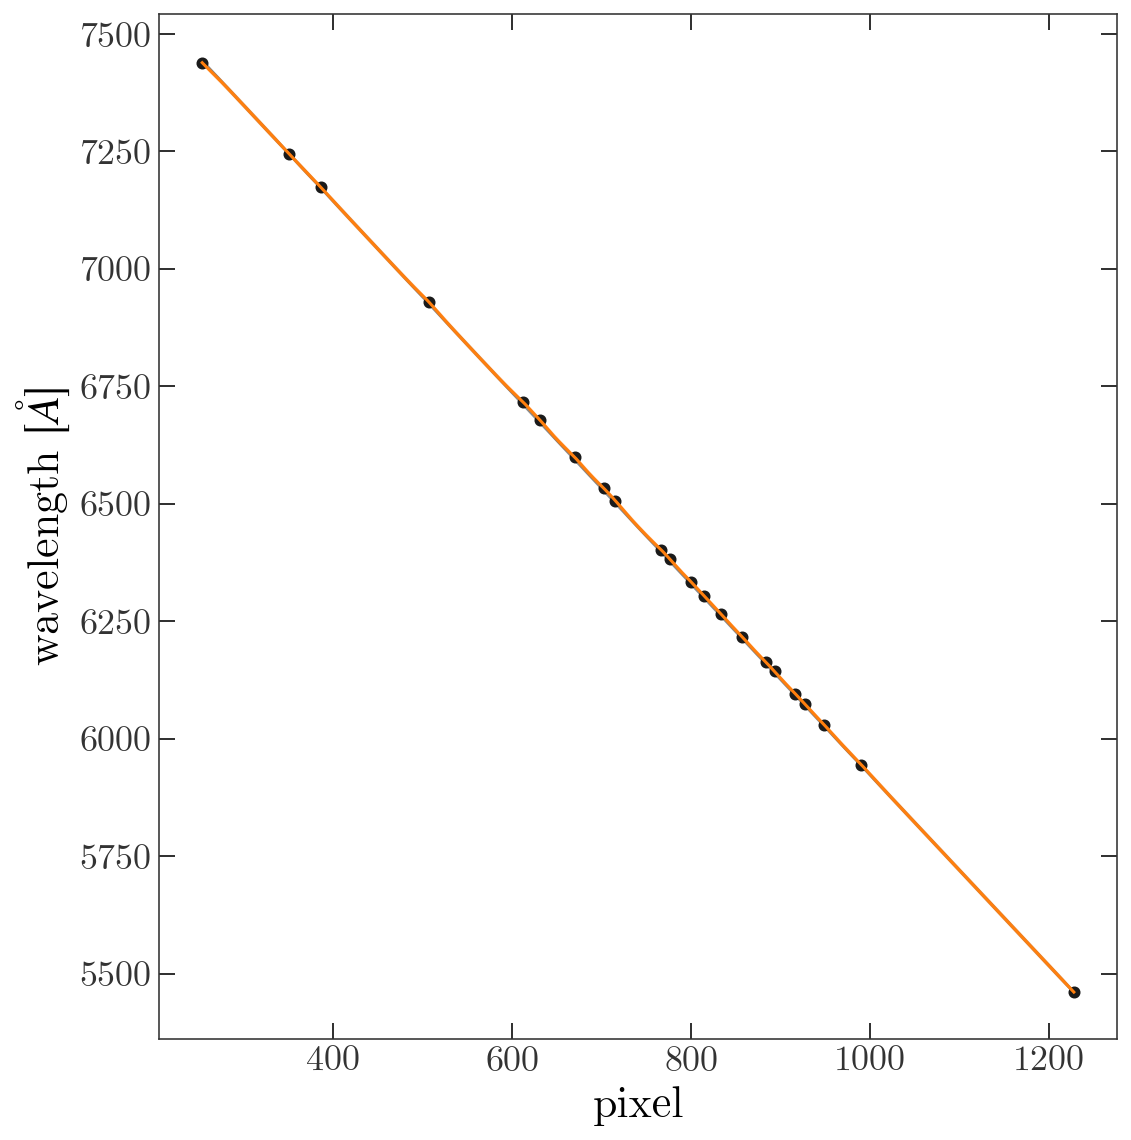

In [379]:
# Make the maximum likelihood prediction
x_grid = np.linspace(x.min(), x.max(), 1024)
mu, var = gp.predict(y, x_grid, return_var=True)
std = np.sqrt(var)

# Plot the maximum likelihood model
fig,ax = plt.subplots(1, 1, figsize=(8,8))

# data
ax.scatter(x + med_x, y, marker='o')

# mean model
ax.plot(x_grid+med_x, mean_model.get_value(x_grid), marker='', alpha=0.5)

# full GP model
gp_color = "#ff7f0e"
ax.plot(x_grid+med_x, mu, color=gp_color, marker='')
ax.fill_between(x_grid+med_x, mu+std, mu-std, color=gp_color,
                alpha=0.3, edgecolor="none")

ax.set_xlabel('pixel')
ax.set_ylabel(r'wavelength [$\AA$]')

fig.tight_layout()

In [380]:
fit_par_dict = gp.get_parameter_dict()
fit_par_dict

OrderedDict([('kernel:log_sigma', 1.179408705652099),
             ('kernel:log_rho', 2.5671624324401656),
             ('mean:a0', 6354.4518845450602),
             ('mean:a1', -2.0345551750664148),
             ('mean:a2', 5.8549766583453214e-06)])

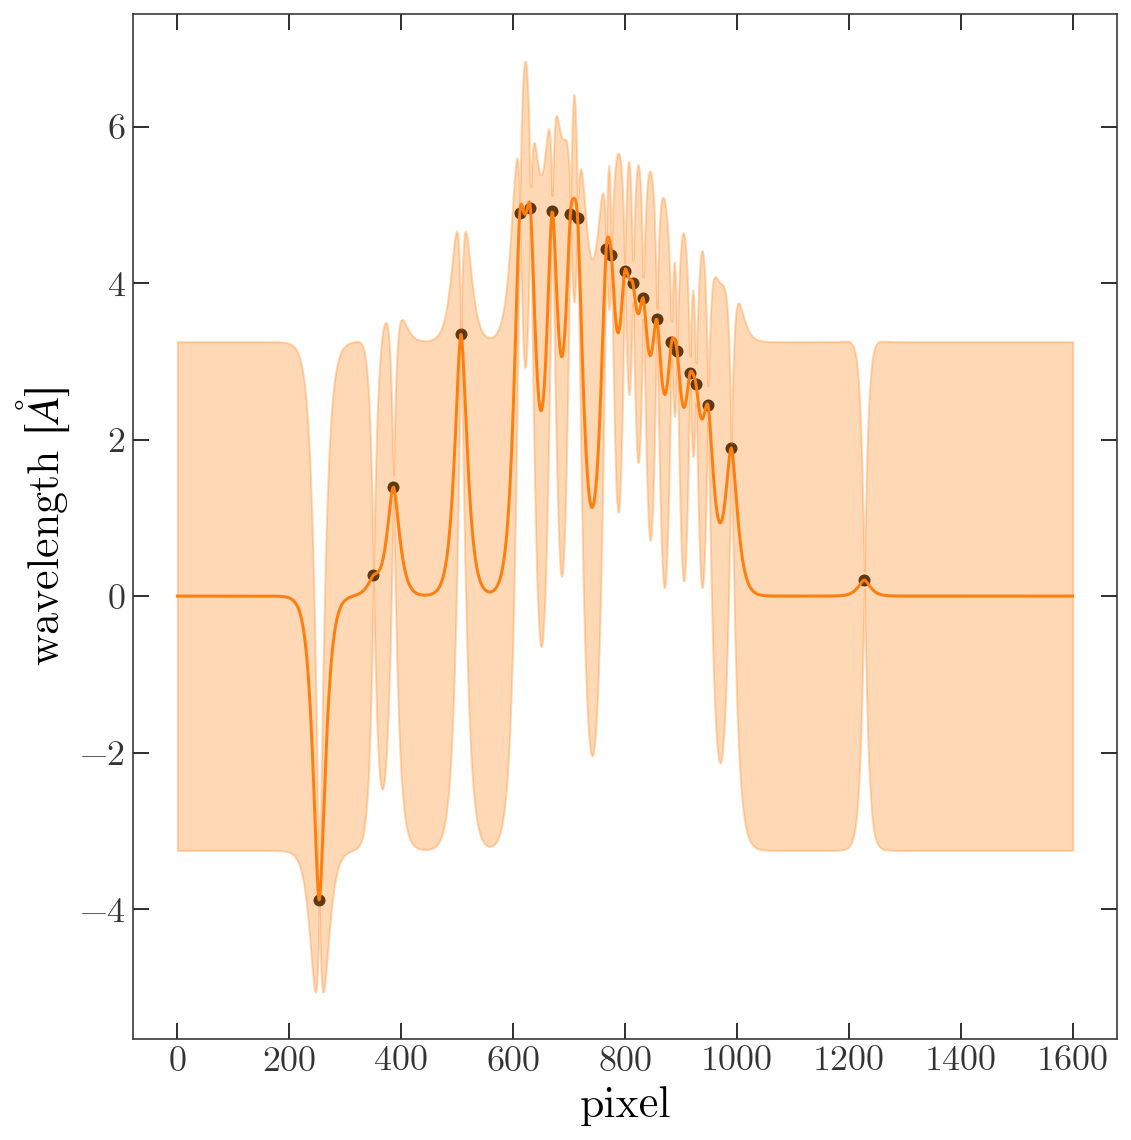

In [381]:
# pars = OrderedDict([('kernel:log_sigma', 1.35323184633239),
#                     ('kernel:log_rho', 10.9297580415762852),
#                     ('mean:a0', 6302.065931604905),
#                     ('mean:a1', -2.061369375358967)])
# gp.set_parameter_vector(list(pars.values()))

# Make the maximum likelihood prediction
# x_grid = np.linspace(x.min(), x.max(), 1024)
x_grid = np.linspace(0, 1600, 1024)- med_x
mu, var = gp.predict(y, x_grid, return_var=True)
std = np.sqrt(var)

_y_mean = mean_model.get_value(x)
_mu_mean = mean_model.get_value(x_grid)

# Plot the maximum likelihood model
fig,ax = plt.subplots(1, 1, figsize=(8,8))

# data
ax.scatter(x + med_x, y - _y_mean, marker='o')

# full GP model
gp_color = "#ff7f0e"
ax.plot(x_grid+med_x, mu - _mu_mean, color=gp_color, marker='')
ax.fill_between(x_grid+med_x, mu+std-_mu_mean, mu-std-_mu_mean, color=gp_color,
                alpha=0.3, edgecolor="none")

ax.set_xlabel('pixel')
ax.set_ylabel(r'wavelength [$\AA$]')

fig.tight_layout()

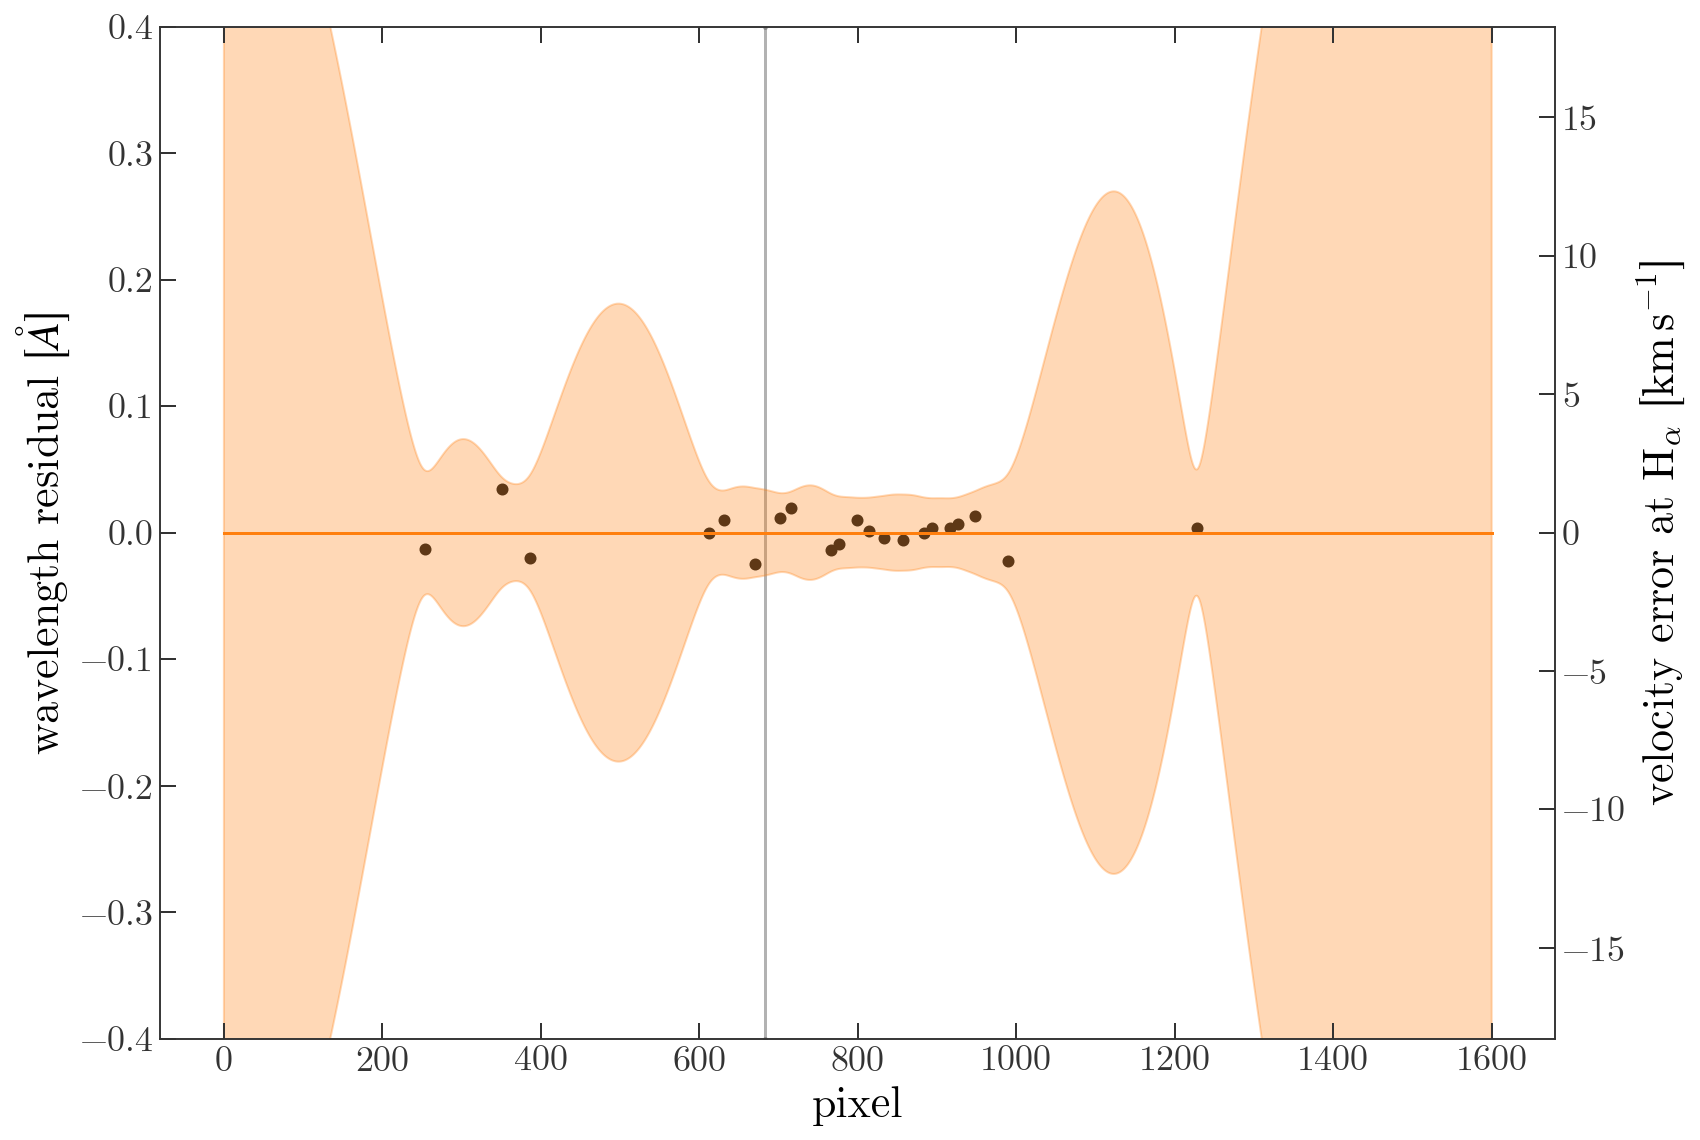

In [370]:
# Make the maximum likelihood prediction
x_grid = np.linspace(0, 1600, 1024)- med_x
mu, var = gp.predict(y, x_grid, return_var=True)
std = np.sqrt(var)

y_mu, var = gp.predict(y, x, return_var=True)

# Plot the maximum likelihood model
fig,ax = plt.subplots(1, 1, figsize=(12,8))

# data
ax.scatter(x + med_x, y - y_mu, marker='o')

# full GP model
gp_color = "#ff7f0e"
ax.plot(x_grid+med_x, mu-mu, color=gp_color, marker='')
ax.fill_between(x_grid+med_x, std, -std, color=gp_color,
                alpha=0.3, edgecolor="none")

ax.set_xlabel('pixel')
ax.set_ylabel(r'wavelength residual [$\AA$]')

ax.set_ylim(-0.4, 0.4)
ax.axvline(683., zorder=-10, color='#666666', alpha=0.5)

ax2 = ax.twinx()
ax2.set_ylim([x/6563*300000 for x in ax.get_ylim()])
ax2.set_ylabel(r'velocity error at ${{\rm H}}_\alpha$ [{}]'.format((u.km/u.s).to_string(format='latex_inline')))

fig.tight_layout()

In [220]:
mu,var = gp.predict(y, 815.-med_x, return_var=True)
mu, np.sqrt(var), np.sqrt(var) / mu * 300000

(array([ 6302.70629063]), array([ 0.03391366]), array([ 1.61424268]))

In [221]:
mu,var = gp.predict(y, 687.63-med_x, return_var=True)
mu, np.sqrt(var), np.sqrt(var) / mu * 300000

(array([ 6562.82094407]), array([ 0.0445813]), array([ 2.0379028]))

In [222]:
mu,var = gp.predict(y, 1172-med_x, return_var=True)
mu, np.sqrt(var), np.sqrt(var) / mu * 300000

(array([ 5577.36507125]), array([ 1.16704297]), array([ 62.77388825]))

In [293]:
column_range = [100,200]

In [294]:
slice(*column_range)

slice(100, 200, None)